# Skin cancer detection using CNNs

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
import random

AUTO = tf.data.experimental.AUTOTUNE

In [196]:
# Function to safely load images
def safe_image_load(image_path):
    try:
        return np.array(Image.open(image_path))
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return np.zeros((224, 224, 3))  # Return a placeholder image

In [197]:
# Load images
images = glob('skin_cancer_detection/data/skin_cancer/*/*.jpg')
images = random.sample(images, 500)  # Randomly sample 500 images
print(f"Total images: {len(images)}")

Total images: 500


In [198]:
# Create data frame [filepath, label]
data = pd.DataFrame({'filepath': images})
data['label'] = data['filepath'].apply(lambda x: x.split('/')[-2])  # Dynamically extract label
data.head()

,filepath,label
0,skin_cancer_detection/data/skin_cancer/maligna...,malignant
1,skin_cancer_detection/data/skin_cancer/maligna...,malignant
2,skin_cancer_detection/data/skin_cancer/maligna...,malignant
3,skin_cancer_detection/data/skin_cancer/maligna...,malignant
4,skin_cancer_detection/data/skin_cancer/benign/...,benign


In [199]:
# Convert labels to binary
data['label_bin'] = np.where(data['label'].values == 'malignant', 1, 0)
data.head()

,filepath,label,label_bin
0,skin_cancer_detection/data/skin_cancer/maligna...,malignant,1
1,skin_cancer_detection/data/skin_cancer/maligna...,malignant,1
2,skin_cancer_detection/data/skin_cancer/maligna...,malignant,1
3,skin_cancer_detection/data/skin_cancer/maligna...,malignant,1
4,skin_cancer_detection/data/skin_cancer/benign/...,benign,0


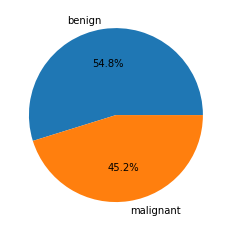

In [200]:
# Make a pie chart
count = data['label'].value_counts()
plt.pie(count.values, labels=count.index, autopct='%1.1f%%')
plt.show()

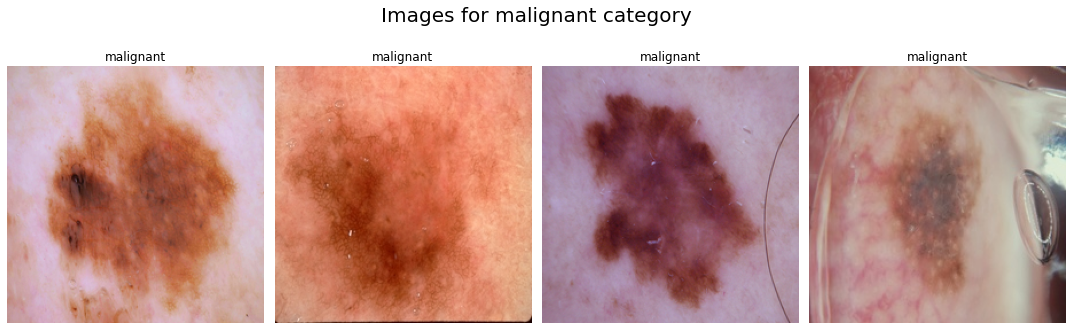

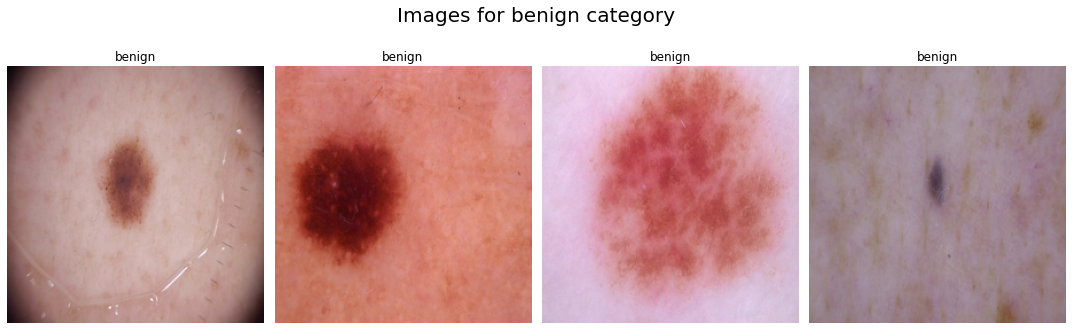

In [ ]:
# Visualize sample images for each category
for cat in data['label'].unique():
    temp = data[data['label'] == cat]
    index_list = temp.index
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category', fontsize=20)
    
    for i in range(4):
        index = np.random.randint(0, len(index_list))
        index_value = index_list[index]
        
        image_path = data.loc[index_value, 'filepath']
        img = safe_image_load(image_path)  
        ax[i].imshow(img)
        ax[i].set_title(cat)  
        ax[i].axis('off') 

    plt.tight_layout()
    plt.show()

In [202]:
# Decode and augment images
def decode_and_augment_image(filepath, label=None):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [224, 224])
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)  # Random contrast
    img = tf.cast(img, tf.float32) / 255.0  # Normalize
    return img, label

# Function to decode and preprocess images
def decode_image(filepath, label=None):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0  # Normalize image

    return img, label

Here, I use CNNs to process the spatial information. I don't use a lot of data and the model is prone to overfitting. For this reason, I added regularization to the inner dense layer.

In [203]:
# Separate features from target
features = data['filepath']
target = data['label_bin']

# Split data
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=10)

# Create TensorFlow datasets
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_and_augment_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

# Define the model architecture
inputs = layers.Input(shape=(224, 224, 3))
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 186624)            0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               238

In [204]:
# Compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['AUC']
)

# Define callbacks for training
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('skin_cancer_detection/best_model.h5', save_best_only=True)
]

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks, verbose=1)

Epoch 1/10
13/13 [==============================] - 37s 3s/step - loss: 2.9400 - auc: 0.5339 - val_loss: 2.2276 - val_auc: 0.6607
Epoch 2/10
13/13 [==============================] - 54s 4s/step - loss: 1.9599 - auc: 0.6415 - val_loss: 1.6083 - val_auc: 0.6899
Epoch 3/10
13/13 [==============================] - 66s 5s/step - loss: 1.4286 - auc: 0.7446 - val_loss: 1.2836 - val_auc: 0.7194
Epoch 4/10
13/13 [==============================] - 54s 4s/step - loss: 1.1810 - auc: 0.7634 - val_loss: 1.1179 - val_auc: 0.7592
Epoch 5/10
13/13 [==============================] - 41s 3s/step - loss: 1.0413 - auc: 0.7999 - val_loss: 1.0286 - val_auc: 0.7537
Epoch 6/10
13/13 [==============================] - 40s 3s/step - loss: 0.9679 - auc: 0.7949 - val_loss: 0.9532 - val_auc: 0.7726
Epoch 7/10
13/13 [==============================] - 51s 4s/step - loss: 0.9062 - auc: 0.8191 - val_loss: 0.8864 - val_auc: 0.8030
Epoch 8/10
13/13 [==============================] - 74s 6s/step - loss: 0.8651 - auc: 0.82

In [205]:
# Save history
with open('skin_cancer_detection/history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# Load model
model = load_model('skin_cancer_detection/best_model.h5')

In [206]:
# Plot loss and AUC
hist_data = pd.DataFrame(history.history)
hist_data

,loss,auc,val_loss,val_auc
0,2.940022,0.533917,2.227610,0.660714
1,1.959923,0.641480,1.608289,0.689860
2,1.428610,0.744628,1.283626,0.719417
3,1.180975,0.763373,1.117920,0.759236
4,1.041284,0.799945,1.028557,0.753695
5,0.967928,0.794887,0.953162,0.772578
6,0.906189,0.819080,0.886374,0.802956
7,0.865098,0.824439,0.837482,0.820813
8,0.791289,0.858872,0.797417,0.830254
9,0.758308,0.866923,0.770004,0.845443


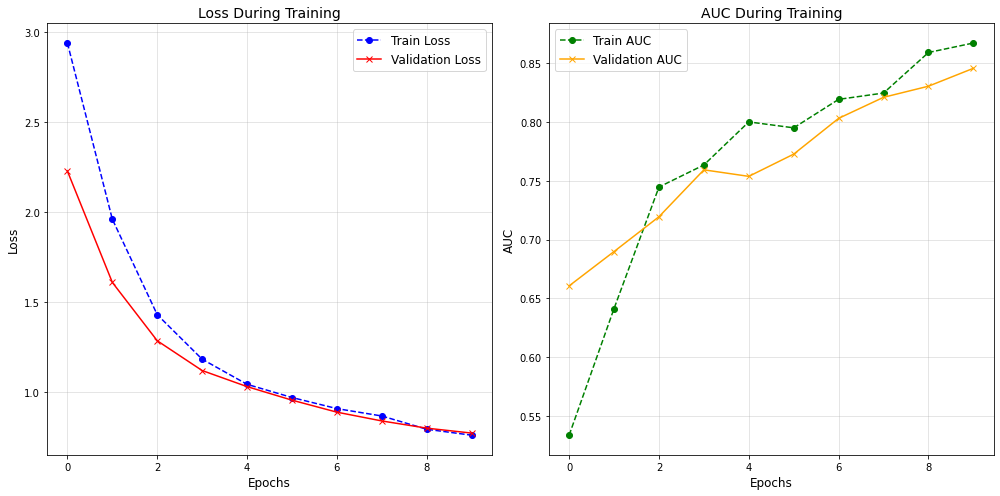

In [207]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, PrecisionRecallDisplay

# Plot training progress with loss and AUC
def plot_training_progress(hist_data):
    plt.figure(figsize=(14, 7))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(hist_data['loss'], label='Train Loss', color='blue', linestyle='--', marker='o')
    plt.plot(hist_data['val_loss'], label='Validation Loss', color='red', linestyle='-', marker='x')
    plt.title('Loss During Training', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.4)

    # AUC
    plt.subplot(1, 2, 2)
    plt.plot(hist_data['auc'], label='Train AUC', color='green', linestyle='--', marker='o')
    plt.plot(hist_data['val_auc'], label='Validation AUC', color='orange', linestyle='-', marker='x')
    plt.title('AUC During Training', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('AUC', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.4)

    plt.tight_layout()
    plt.show()

plot_training_progress(hist_data)